# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Nguyễn Thái Đan Sâm
- MSSV: 21127414
- Lớp: 21CLC01

# Import

In [374]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Đọc dữ liệu

In [375]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa các đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu kiểm tra)

X_test = test.iloc[:, :-1]      # Dataframe (chứa các đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần

# Cài đặt hàm

In [376]:
# Cài đặt các hàm cần thiết ở đây
#1a
class OLSLinearRegression:
    def fit(self, X, y):
        X_pinv = np.linalg.inv(X.T @ X) @ X.T   
        self.w = X_pinv @ y
        return self

    def get_params(self):
        return self.w

    def predict(self, X):
        return np.sum(self.w.ravel() * X, axis=1)   
    
    def get_value(self):
        Coeficient = np.round(self.w,3)
        for i in range(1, self.w.size):
            Interception = np.round(abs(self.w[i]), 3)
        return Coeficient, Interception
    
def MAE(X, y, model):
    y_prediction=model.predict(X)
    return metrics.mean_absolute_error(y,y_prediction)

def pre_Process(X):
    return np.hstack((X,np.ones((X.shape[0],1))))


In [377]:
#1b,1c
def k_fold_cross_validation(x_value, y_value, feature, k=5):
    fold_mae_scores = []

    fold_size = len(x_value) // k

    for fold in range(k):
        start_idx = fold * fold_size
        end_idx = (fold + 1) * fold_size
        
        X_fold_train = x_value.iloc[np.r_[:start_idx, end_idx:]].loc[:, [feature]]
        y_fold_train = y_value.iloc[np.r_[:start_idx, end_idx:]]
        
        X_fold_val = x_value.iloc[start_idx:end_idx].loc[:, [feature]]
        y_fold_val = y_value.iloc[start_idx:end_idx]
        
        # Train a linear regression model on the fold
        X_fold_train_with_bias = pre_Process(X_fold_train)
        model = OLSLinearRegression()
        weights = model.fit(X_fold_train_with_bias,y_fold_train)

        # Preprocess
        X_fold_val_with_bias = pre_Process(X_fold_val)
        
        # Calculate MAE
        fold_mae_scores.append(MAE(X_fold_val_with_bias,y_fold_val.to_numpy(), weights))
    
    mean_mae = np.mean(fold_mae_scores)
    return mean_mae

def find_best_feature(x_value, y_value, list_features, k=5):
    mae_scores = {}

    for feature in list_features:
        mean_mae = k_fold_cross_validation(x_value, y_value, feature, k)
        mae_scores[feature] = mean_mae

    return mae_scores

# Shuffle date
def shuffle_data(X_value, y_value, random_state=42):
    # Combine X_train and y_train for shuffling
    combined_data = pd.concat([X_value, y_value], axis=1)
    
    # Shuffle the combined data
    shuffled_data = combined_data.sample(frac=1, random_state=random_state)
    
    # Split shuffled data back into X_train and y_train
    X_value_shuffled = shuffled_data.drop(columns=['Salary'])
    y_value_shuffled = shuffled_data['Salary']
    
    return X_value_shuffled, y_value_shuffled


# Yêu cầu 1a: Sử dụng toàn bộ 11 đặc trưng đầu tiên `Gender`, `10percentage`, `12percentage`, `CollegeTier`, `Degree`, `collegeGPA`, `CollegeCityTier`, `English`, `Logical`, `Quant`, `Domain` (2 điểm) 

In [378]:
# Phần code cho yêu cầu 1a
X_train1=X_train.iloc[:,:11].to_numpy()
X_test1 = X_test.iloc[:,:11].to_numpy()
y_train1=y_train.to_numpy()
y_test1 = y_test.to_numpy()

X_1a=pre_Process(X_train1)
model1a=OLSLinearRegression().fit(X_1a,y_train1)
np.round(model1a.get_params(),3)

array([-23183.33 ,    702.767,   1259.019, -99570.608,  18369.962,
         1297.532,  -8836.727,    141.76 ,    145.742,    114.643,
        34955.75 ,  49248.09 ])

In [379]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
print('The value MAE of the Test Data:', np.round(MAE(pre_Process(X_test1),y_test1,model1a)),3)

The value MAE of the Test Data: 105053.0 3


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} =  -23183.330*Gender+702.767*10percentage+1259.019*12percentage-99570.608*CollegeTier+18369.962*Degree+1297.532*collegeGPA -8836.727*CollegeCityTier+141.760*English+145.742*Logical+114.643*Quant+34955.750*Domain+49248.090$$

# Yêu cầu 1b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng tính cách với các đặc trưng tính cách gồm `conscientiousness`, `agreeableness`, `extraversion`, `nueroticism`, `openess_to_experience`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [380]:
# Phần code cho yêu cầu 1b
# Tìm ra đặc trưng tốt nhất
# In ra các kết quả cross-validation như yêu cầu

X_1b=X_train.iloc[:,18:]

X_train_shuffled, y_train_shuffled = shuffle_data(X_train, y_train)
mae_scores = find_best_feature(X_train_shuffled, y_train_shuffled, X_1b, k = 5)

best_feature = min(mae_scores, key=mae_scores.get)
print(f"The best personality feature: {best_feature}")

best_mae = np.round(mae_scores[best_feature],3)
print(f"The value MAE of the best feature: {best_mae}")

prediction = pd.DataFrame(mae_scores.items(), columns=['Feature', 'MAE'])
prediction



The best personality feature: nueroticism
The value MAE of the best feature: 123067.985


,Feature,MAE
0,conscientiousness,124016.187460
1,agreeableness,123098.142270
2,extraversion,123668.596905
3,nueroticism,123067.984574
4,openess_to_experience,123687.015610


In [381]:
best_feature_column = X_train_shuffled[best_feature].to_numpy().reshape(-1, 1) 

X_train_bias=pre_Process(best_feature_column)

# Train the model on the entire training dataset with the best feature
model1b = OLSLinearRegression().fit(X_train_bias,y_train_shuffled)

# Evaluate the model on the training dataset by calculating MAE
mae_train = np.round(MAE(X_train_bias,y_train_shuffled, model1b),3)

print("The value MAE of the Train Data:", mae_train)

# Print the weights (coefficients) of the trained model
print("Coeficient and interception: ",np.round(model1b.get_params(),3))

The value MAE of the Train Data: 123388.238
Coeficient and interception:  [-16021.494 304647.553]


In [382]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_personality_feature_model
X_test_shuffled, y_test_shuffled = shuffle_data(X_test, y_test)
best_feature_column_test = X_test_shuffled[best_feature].to_numpy().reshape(-1, 1)

X_test_bias=pre_Process(best_feature_column_test)

# Calculate MAE on the test dataset
mae_test = np.round(MAE(X_test_bias,y_test_shuffled, model1b),3)
print("The value MAE of the Test Data:", mae_test)

The value MAE of the Test Data: 119361.917


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = -16021.494*nueroticism + 304647.553$$

# Yêu cầu 1c: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng `English`, `Logical`, `Quant`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [383]:
# Phần code cho yêu cầu 1c
# Tìm ra đặc trưng tốt nhất
# In ra các kết quả cross-validation như yêu cầu

X_1c=X_train[['English','Logical','Quant']]

X_train_shuffled, y_train_shuffled = shuffle_data(X_train, y_train)
mae_scores = find_best_feature(X_train_shuffled, y_train_shuffled, X_1c, k = 5)

best_feature = min(mae_scores, key=mae_scores.get)
print(f"The best personality feature: {best_feature}")

best_mae = np.round(mae_scores[best_feature],3)
print(f"The value MAE of the best feature: {best_mae}")

prediction = pd.DataFrame(mae_scores.items(), columns=['Feature', 'MAE'])
prediction


The best personality feature: Quant
The value MAE of the best feature: 116865.817


,Feature,MAE
0,English,120121.858199
1,Logical,119460.779750
2,Quant,116865.817199


In [384]:
# Huấn luyện lại mô hình best_skill_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
best_feature_column = X_train_shuffled[best_feature].to_numpy().reshape(-1, 1) 

X_train_bias=pre_Process(best_feature_column)

# Train the model on the entire training dataset with the best feature
model1c = OLSLinearRegression().fit(X_train_bias,y_train_shuffled)

# Evaluate the model on the training dataset by calculating MAE
mae_train = np.round(MAE(X_train_bias,y_train_shuffled, model1c),3)         

print("The value MAE of the Train Data:", mae_train)

# Print the weights (coefficients) of the trained model
print("Coeficient and interception: ",np.round(model1c.get_params(),3))

The value MAE of the Train Data: 117166.197
Coeficient and interception:  [   368.852 117759.729]


In [385]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_personality_feature_model
X_test_shuffled, y_test_shuffled = shuffle_data(X_test, y_test)
best_feature_column_test = X_test_shuffled[best_feature].to_numpy().reshape(-1, 1)

X_test_bias=pre_Process(best_feature_column_test)

# Make predictions on the test dataset using the trained model
predictions_test = model1c.predict(X_test_bias)

# Calculate MAE on the test dataset
mae_test = MAE(X_test_bias,y_test_shuffled, model1c)
print("The value MAE of the Test Data:", mae_test)

The value MAE of the Test Data: 108814.05968837175


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 368.852*Quant+117759.729$$

# Yêu cầu 1d: Sinh viên tự xây dựng mô hình, tìm mô hình cho kết quả tốt nhất (3 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

## Tìm mô hình

<Axes: >

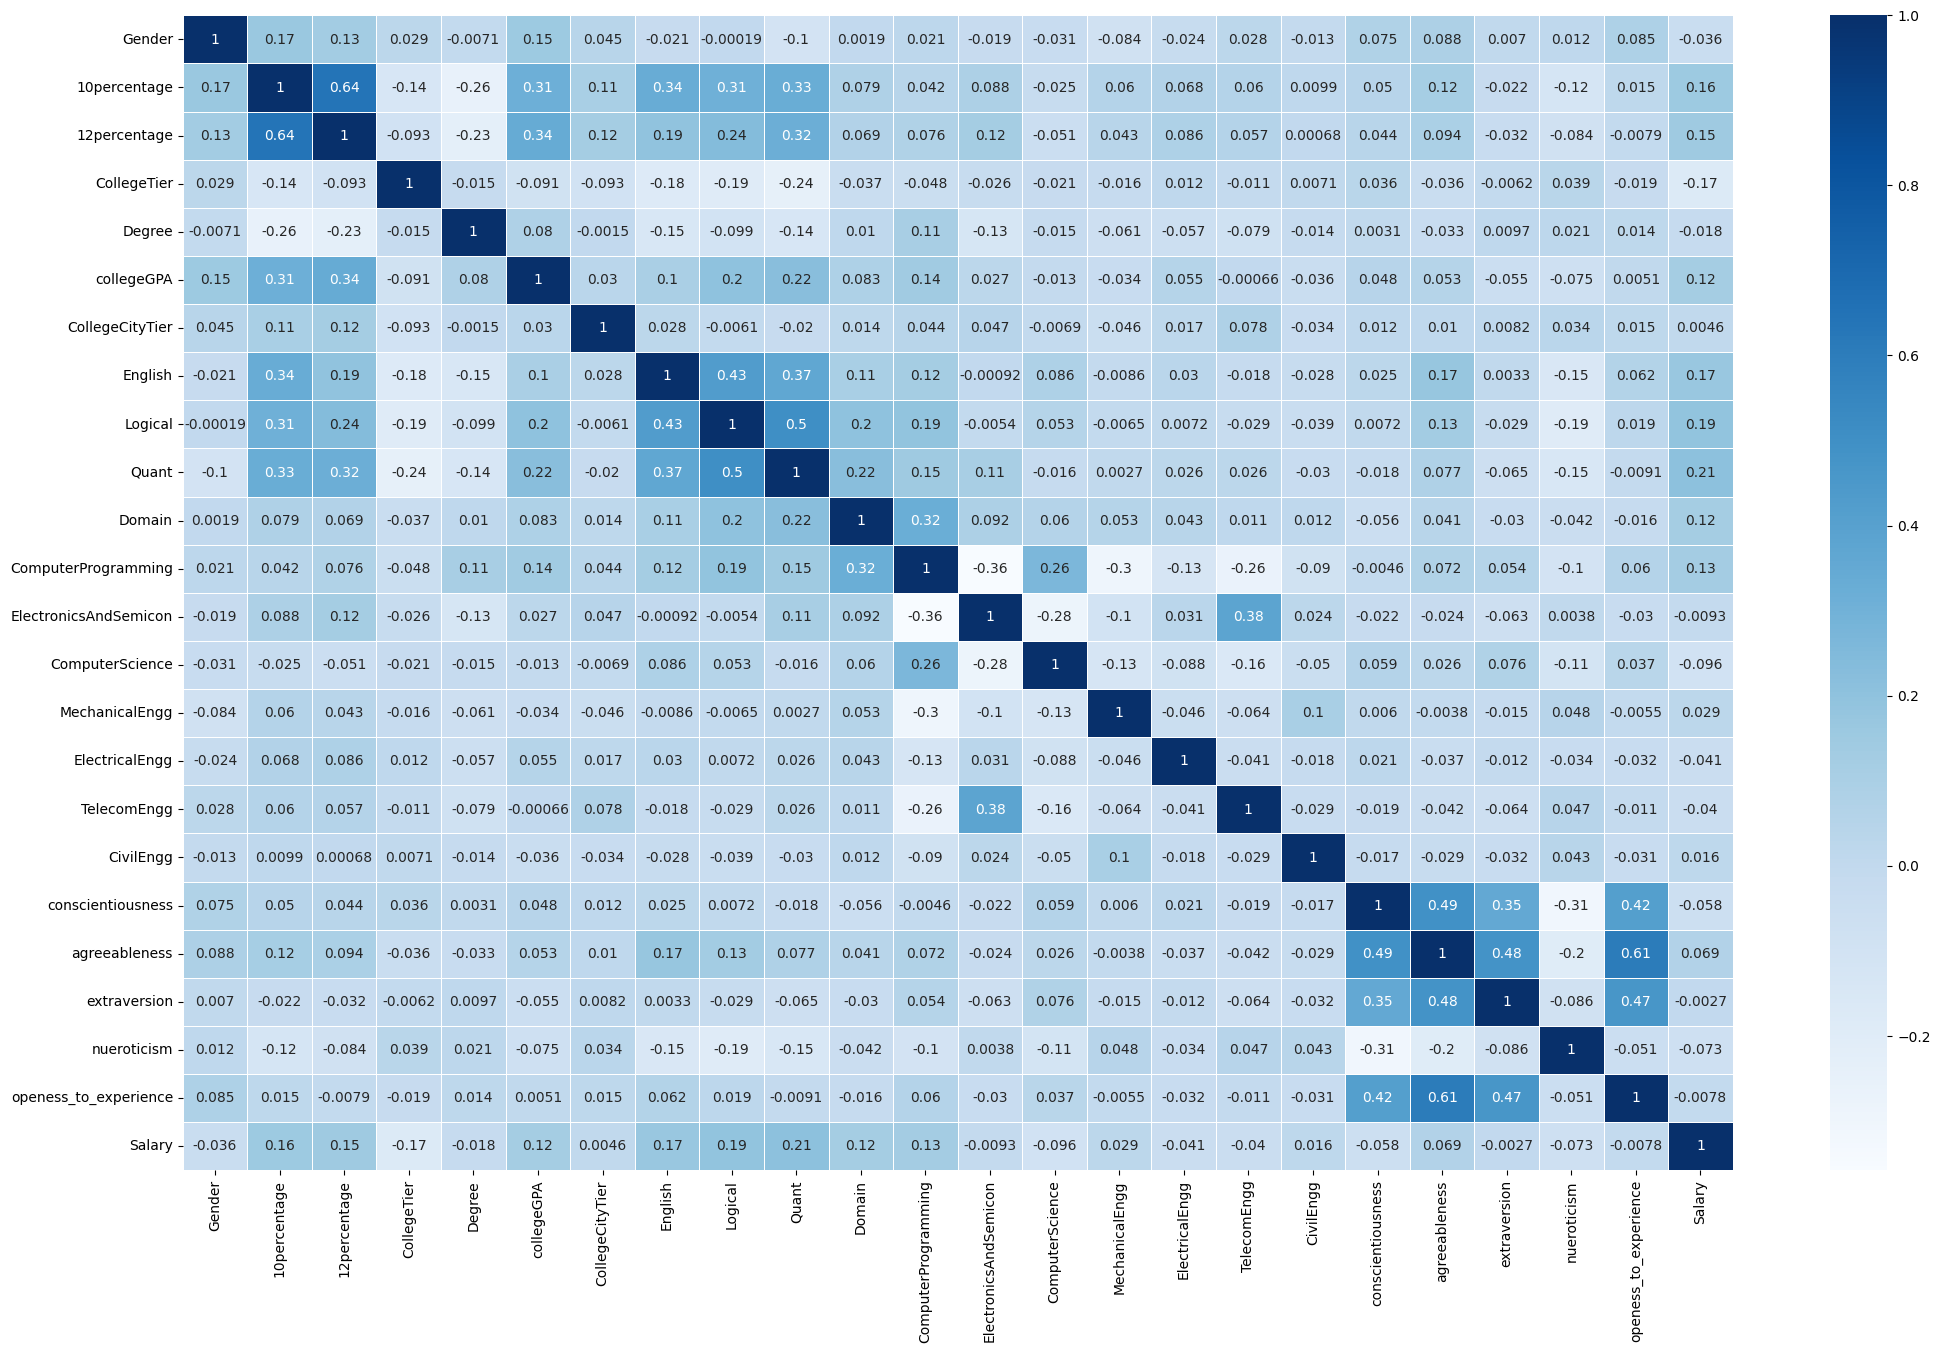

In [386]:
corr_matrix = train.corr()
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(corr_matrix,cmap="Blues", annot=True, linewidths=.5, ax = ax)

## Thử nghiệm, so sánh các mô hình

In [387]:
# Model 1
features_1=['10percentage','12percentage','collegeGPA','Domain','Quant','ComputerProgramming','ComputerScience']

X_train_d1 = X_train[features_1]
X_test_d1 = X_test[features_1]

X_train_shuffled, y_train_shuffled = shuffle_data(X_train_d1, y_train)
X_test_shuffled,y_test_shuffled = shuffle_data(X_test_d1, y_test)

    # Calculate MAE in Train Data
X_train_bias=pre_Process(X_train_shuffled)
model1 = OLSLinearRegression().fit(X_train_bias,y_train_shuffled)
mae_train = np.round(MAE(X_train_bias,y_train_shuffled, model1),3)         
print("The value MAE of the Train Data:", mae_train)

    # Calculate MAE in Test Data
X_test_bias = pre_Process(X_test_shuffled)
print('The value MAE of the Test Data: ', np.round(MAE(X_test_bias,y_test_shuffled,model1),3))
np.round(model1.get_params(),3)

The value MAE of the Train Data: 111322.059
The value MAE of the Test Data:  101702.94


array([  1457.604,    657.068,   1087.317,  25130.476,    241.263,
          120.169,   -152.243, -97310.393])

In [388]:
def add_features(data):
    data.insert(0, 'School', (data['10percentage']*data['12percentage']*data['collegeGPA']))
    data.insert(0, 'Major', (data['ComputerProgramming']*data['ComputerScience']))
    data.insert(0, 'Life', (data['English']*data['Logical']*data['Quant']))
    return pd.DataFrame(data)

# Model 2

X_1d_train = add_features(X_train)
X_1d_test = add_features(X_test)

features_2=['School','Major','Life','ComputerProgramming','Domain']

X_train_d2 = X_1d_train[features_2]
X_test_d2 = X_1d_test[features_2]
X_train_shuffled, y_train_shuffled = shuffle_data(X_train_d2, y_train)
X_test_shuffled, y_test_shuffled = shuffle_data(X_test_d2, y_test)

    # Calculate MAE in Train Data
X_train_bias=pre_Process(X_train_shuffled)
model2 = OLSLinearRegression().fit(X_train_bias,y_train_shuffled)
mae_train = np.round(MAE(X_train_bias,y_train_shuffled, model2),3)         
print("The value MAE of the Train Data:", mae_train)

    # Calculate MAE in Test Data
X_test_bias = pre_Process(X_test_shuffled)
print('The value MAE of the Test Data: ', np.round(MAE(X_test_bias,y_test_shuffled,model2),3))
np.round(model2.get_params(),3)



The value MAE of the Train Data: 111763.327
The value MAE of the Test Data:  104069.534


array([ 1.59000000e-01, -3.21000000e-01,  1.00000000e-03,  1.18229000e+02,
        2.31962370e+04,  1.16211239e+05])

In [389]:
def add_features(data):
    data.insert(0, 'Learning', (np.mean(data['ComputerProgramming']+data['Quant']+data['ComputerScience']+data['collegeGPA']+data['English'])))
    return pd.DataFrame(data)

# Model 3
X_1d_train = add_features(X_train)
X_1d_test = add_features(X_test)

features_3=['Learning','Quant','ComputerScience','ComputerProgramming','collegeGPA','English']

X_train_d3 = X_1d_train[features_3]
X_test_d3 = X_1d_test[features_3]
X_train_shuffled, y_train_shuffled = shuffle_data(X_train_d3, y_train)
X_test_shuffled, y_test_shuffled = shuffle_data(X_test_d3, y_test)

    # Calculate MAE in Train Data
X_train_bias=pre_Process(X_train_shuffled)
model3 = OLSLinearRegression().fit(X_train_bias,y_train_shuffled)
mae_train = np.round(MAE(X_train_bias,y_train_shuffled, model3),3)         
print("The value MAE of the Train Data:", mae_train)

    # Calculate MAE in Test Data
X_test_bias = pre_Process(X_test_shuffled)
print('The value MAE of the Test Data: ', np.round(MAE(X_test_bias,y_test_shuffled,model3),3))
np.round(model3.get_params(),3)


The value MAE of the Train Data: 110356.067
The value MAE of the Test Data:  102608.508


array([-2.7110000e+00,  2.3340700e+02, -1.6712200e+02,  1.3004100e+02,
        1.7586180e+03,  2.3919000e+02, -9.6840103e+04])

Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Salary} = 1457.603*10percentage+657.067*12percentage+ 1087.317*CollegeGPA   + 241.263*Quant+ 25130.476*Domain
+ 120.169*ComputerProgramming  -152.243*ComputerScience - 97310.3932$$